### 목표
- 네이버 영화 리뷰의 그으정, 부정을 예측하는 순환 신경망 모델을 만들어보자!
- 학습용 데이터가 아닌 실제리뷰(텍스트) 데이터를 전처리해서 신경망에 넣어보자

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 46.3 MB/s eta 0:00:00


In [6]:
%cd /content/drive/MyDrive/Colab Notebooks/17.SW 캠프 데이터 비즈니스 과정

/content/drive/MyDrive/Colab Notebooks/17.SW 캠프 데이터 비즈니스 과정


In [7]:
df_train = pd.read_csv('data/ratings_train.txt', delimiter='\t')
df_test = pd.read_csv('data/ratings_test.txt', delimiter='\t')


In [8]:
df_train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [11]:
# 결측치가 존재하는 행 제거
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149995 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        149995 non-null  int64 
 1   document  149995 non-null  object
 2   label     149995 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


- 문제, 정답 데이터로 분리

In [13]:
# id 컬럼은 분석에 큰 영향이 없을 것 같으니 제외
X_train = df_train['document']
y_train = df_train['label']
X_test = df_test['document']
y_test = df_test['label']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)




(149995,)
(149995,)
(49997,)
(49997,)


In [14]:
X_train

0                                       아 더빙.. 진짜 짜증나네요 목소리
1                         흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                             교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
                                ...                        
149995                                  인간이 문제지.. 소는 뭔죄인가..
149996                                        평점이 너무 낮아서...
149997                      이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?
149998                          청춘 영화의 최고봉.방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 149995, dtype: object

### konlpy의 형태소 분석기(문장을 형태소로 분리해주는 도구) 종류
- Kkma : 서울대학교 데이터 랩에서 개발, 일반적인 성능은 좋으나 분석시간이 konlpy 형태소 분석기 중 가장 오래걸림
- Okt : twitter에서 개발, twitter 데이터를 기반으로 형태소를 추출하기 때문에 인터넷 텍스트에 특화되어 잇고, 비표준어, 비속어 등이 포함되어 있는 정제되지 않는 데이터 처리에 강함 + 추가로 konlpy 형태소 분석기 중 유일하게 stemming(어간추출) 기능을 포함하고 있음, 속도는 준수하나 동음이의어 처리가 어렵고 , 분석 법주가 다른 형태소 분석기에 비해 좁은 단점
- Komoran : Shineware에서 개발, 오탈자에 대해 분석 품질은 좋으나 띄워쓰기가 없는 문장을 분석하는데 좋지 않음
- Hannanum : KAIST에서 개발, 띄워쓰기가 없는 문장에서 분석 품질이 좋지 않음
- Mecab : 일본어용 형태소 분석기를 한국어에 사용할 수 있도록 수정한 분석기, 속도가 5개 중 가장 빠르나 window에서 설치가 힘들고 동음이의어 처리가 취약함

위 다섯개 형태소 분석기 모두 nouns, morphs, pos 함수를 지원
- nouns : 주어진 문장의 명사를 추출
- morphs : 주어진 문장의 형태소를 추출
- pos : 주어진 문장의 형태소와 각 단어의 품사를 식별하여 태그를 추가해 함께 출력(품사 태깅)

In [15]:
# 인터넷 영화 리뷰를 분석하는데 적합한 Okt 형태소 분석기 임포트
from konlpy.tag import Okt
from tqdm import tqdm
import pickle

In [16]:
okt =Okt()

In [17]:
# 형태소 추출 후 공백을 주면서 각각의 문장으로 연결(뒤에 이어질 토큰화에서 공백 기준으로 토큰화시켜주기 위함
# 긴 문장이나 띄워쓰기가 잘 되어있지 않는 경우 토큰화의 성능이 좋지 않기 때문에 문장을 형태소로
# 분리한 후 공백을 줘서 다시 문장으로 재구성함!
X_train_morphs = [' '.join(okt.morphs(doc)) for doc in tqdm(X_train)]
X_test_morphs = [' '.join(okt.morphs(doc)) for doc in tqdm(X_test)]

100%|██████████| 49997/49997 [01:59<00:00, 418.67it/s]


In [18]:
X_train_morphs

['아 더빙 .. 진짜 짜증나네요 목소리',
 '흠 ... 포스터 보고 초딩 영화 줄 .... 오버 연기 조차 가볍지 않구나',
 '너 무재 밓었 다그 래서 보는것을 추천 한 다',
 '교도소 이야기 구먼 .. 솔직히 재미 는 없다 .. 평점 조정',
 '사이 몬페 그 의 익살스런 연기 가 돋보였던 영화 ! 스파이더맨 에서 늙어 보이기만 했던 커스틴 던스트 가 너무나도 이뻐 보였다',
 '막 걸음 마 뗀 3 세 부터 초등학교 1 학년 생인 8 살용 영화 . ㅋㅋㅋ ... 별 반개 도 아까 움 .',
 '원작 의 긴장감 을 제대로 살려내지못 했다 .',
 '별 반개 도 아깝다 욕 나온다 이응경 길용우 연 기 생활 이 몇 년 인지 .. 정말 발 로 해도 그것 보단 낫겟다 납치 . 감금 만 반복 반복 .. 이 드라마 는 가족 도 없다 연기 못 하는 사람 만 모 엿 네',
 '액션 이 없는데도 재미 있는 몇 안되는 영화',
 '왜케 평점 이 낮은건데 ? 꽤 볼 만 한 데 .. 헐리우드 식 화려함에만 너무 길들여져 있나 ?',
 '걍 인피니트 가 짱 이다 . 진짜 짱 이다 ♥',
 '볼때 마다 눈물나서 죽겠다 90년 대의 향수 자극 !! 허진호 는 감성 절제 멜로 의 달인 이다 ~',
 '울면 서 손 들 고 횡단보도 건널 때 뛰 쳐나 올 뻔 이범수 연기 드럽게 못 해',
 '담백하고 깔끔해서 좋다 . 신 문 기 사 로만 보다 보면 자꾸 잊어버린다 . 그 들 도 사람 이었다는 것 을 .',
 '취향 은 존중 한 다지 만 진짜 내생 에 극장 에서 본 영화 중 가장 노잼 노 감동 임 스토리 도 어거지 고 감동 도 어거지',
 'ㄱ 냥 매번 긴장 되고 재밋음 ㅠㅠ',
 '참 사람 들 웃긴게 바스코 가 이기 면 락스 코 라고 까고 바비 가 이기 면 아이돌 이라고 깐다 . 그냥 까고싶어서 안달 난 것 처럼 보인다',
 '굿바이 레닌 표절 인 것 은 이해 하는데 왜 뒤 로 갈수록 재미 없어지냐',
 '이건 정말 깨알 캐스팅 과 질퍽 하 지 않은 산뜻한 내 용구성 이 잘 버무러진 깨

In [19]:
# pickle 파일로 저장(colab 재접속 시 바로 가공된 데이터를 사용하기 위함)
# pickle : 텍스트 파일이 아닌 데이터의 자료 구조 형태를 그대로 저장하거나 불어오는 모듈
with open('data/X_train_morphs.pkl', 'wb') as f :
  pickle.dump(X_train_morphs, f)

with open('data/X_test_morphs.pkl', 'wb') as f :
  pickle.dump(X_test_morphs, f)

In [20]:
# pickle 파일 로드(형태소로 분리되어 문장화 되어있는 상태 그대로 로드)
with open('data/X_train_morphs.pkl', 'rb') as f :
  X_train = pickle.load(f)
with open('data/X_test_morphs.pkl', 'rb') as f :
  X_test = pickle.load(f)

### keras에서 지원하는 글을 포함하는 토크나이져(Tokenizer)를 사용해서 토큰화 시켜보자!

- keras 지원 Tokenizer 특징 -
- 1) 공백(띄워쓰기) 기준으로 토큰화
- 2) 빈도수 기준으로 자동 레이블 인코딩(로이터 뉴스 데이터 처럼! )
- 3) 기본적인 한국어 정규표현식이 적용

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [22]:
tokenizer = Tokenizer()

In [23]:
# 토크나이저로 학습 후 단어사전(BoW) 생성
tokenizer.fit_on_texts(X_train)

In [24]:
# 각 토큰들의 빈도수에 따른 인코딩 결과(랭킹) 출력
tokenizer.word_index

# '아' 라는 토큰이 가장 많이 사용되으며 1로 인코딩 됨

{'이': 1,
 '영화': 2,
 '의': 3,
 '가': 4,
 '에': 5,
 '을': 6,
 '도': 7,
 '들': 8,
 '는': 9,
 '를': 10,
 '은': 11,
 '너무': 12,
 '한': 13,
 '다': 14,
 '정말': 15,
 '적': 16,
 '만': 17,
 '진짜': 18,
 '점': 19,
 '으로': 20,
 '로': 21,
 '에서': 22,
 '연기': 23,
 '과': 24,
 '평점': 25,
 '것': 26,
 '최고': 27,
 '내': 28,
 '나': 29,
 '그': 30,
 '잘': 31,
 '와': 32,
 '안': 33,
 '인': 34,
 '이런': 35,
 '스토리': 36,
 '생각': 37,
 '못': 38,
 '왜': 39,
 '드라마': 40,
 '1': 41,
 '게': 42,
 '이다': 43,
 '감동': 44,
 '사람': 45,
 '하는': 46,
 '보고': 47,
 '하고': 48,
 '말': 49,
 '고': 50,
 '아': 51,
 '더': 52,
 '때': 53,
 'ㅋㅋ': 54,
 '배우': 55,
 '거': 56,
 '감독': 57,
 '그냥': 58,
 '요': 59,
 '본': 60,
 '재미': 61,
 '내용': 62,
 '뭐': 63,
 '중': 64,
 '까지': 65,
 '좀': 66,
 '쓰레기': 67,
 '보다': 68,
 '없는': 69,
 '시간': 70,
 '수': 71,
 '지': 72,
 '네': 73,
 '10': 74,
 '봤는데': 75,
 '작품': 76,
 '사랑': 77,
 '할': 78,
 '없다': 79,
 '다시': 80,
 '하나': 81,
 '볼': 82,
 '마지막': 83,
 '2': 84,
 '이건': 85,
 'ㅋ': 86,
 '좋은': 87,
 '저': 88,
 '정도': 89,
 '입니다': 90,
 '같은': 91,
 '완전': 92,
 '있는': 93,
 'ㅋㅋㅋ': 94,
 '처음': 95,
 "'":

In [25]:
tokenizer.word_counts

OrderedDict([('아', 4373),
             ('더빙', 573),
             ('진짜', 8343),
             ('짜증나네요', 22),
             ('목소리', 375),
             ('흠', 264),
             ('포스터', 573),
             ('보고', 4702),
             ('초딩', 424),
             ('영화', 50737),
             ('줄', 1240),
             ('오버', 142),
             ('연기', 6434),
             ('조차', 242),
             ('가볍지', 26),
             ('않구나', 3),
             ('너', 687),
             ('무재', 69),
             ('밓었', 1),
             ('다그', 24),
             ('래서', 17),
             ('보는것을', 10),
             ('추천', 1193),
             ('한', 11003),
             ('다', 10264),
             ('교도소', 16),
             ('이야기', 2174),
             ('구먼', 11),
             ('솔직히', 1069),
             ('재미', 3930),
             ('는', 17591),
             ('없다', 2868),
             ('평점', 6324),
             ('조정', 40),
             ('사이', 219),
             ('몬페', 2),
             ('그', 5672),
             ('의', 30963),
  

In [26]:
# BoW에 있는 전체 토큰 개수
len(tokenizer.word_index)

102054

# 빈도가 낮은 토큰 제거하기

In [26]:
tokenizer.word_counts.items()

In [26]:
df = pd.DataFrame(tokenizer.word_counts.items().columns=['Token', 'Count'])
df.head()

In [28]:
df = pd.DataFrame(tokenizer.word_counts.items(),
                  columns=['Token', 'Count']
                  )
df.head()

,Token,Count
0,아,4373
1,더빙,573
2,진짜,8343
3,짜증나네요,22
4,목소리,375


In [29]:
# 정렬 후 출력되는 index는 의미가 없으므로 reset_index로 현재 values 상태 그대로 다시 인덱스를 매겨줌
# 기존 index는 컬럼으로 들어오지만 drop= True로 없애
df_sorted = df.sort_values(by='Count', ascending=False).reset_index(drop=True)
df_sorted

,Token,Count
0,이,56108
1,영화,50737
2,의,30963
3,가,27571
4,에,26772
...,...,...
102049,매조키즘,1
102050,나온거라니,1
102051,맡아던,1
102052,어케해,1


# 등장 빈도가 20번 미만인

In [30]:
# 등장 빈도가 20번 미만인 데이터를 제거하자(최소 20번은 나와야 BoW에 저장하기)
df_sorted[df_sorted['Count'] < 20]

,Token,Count
7852,지루하다는,19
7853,상관없이,19
7854,소라,19
7855,아따,19
7856,살아라,19
...,...,...
102049,매조키즘,1
102050,나온거라니,1
102051,맡아던,1
102052,어케해,1


In [31]:
#num_words : 원하는 인덱스 번호까지만 사용
final_tokenizer = Tokenizer(num_words=7851)

In [32]:
final_tokenizer.fit_on_texts(X_train)

In [34]:
X_train_seq = final_tokenizer.texts_to_sequences(X_train)
X_test_seq = final_tokenizer.texts_to_sequences(X_test)

In [35]:
X_train_seq
# 빈도수가 20회 미만은 데이터는 사용하지 않았기 때문에 단어가 부족할 수 있음

[[51, 451, 18, 7034, 659],
 [910, 452, 47, 608, 2, 203, 1582, 23, 986, 6213],
 [376, 2900, 6589, 207, 13, 14],
 [110, 223, 61, 9, 79, 25, 4472],
 [1076, 30, 3, 23, 4, 6590, 2, 3103, 22, 5441, 476, 4, 1127, 3928, 4568],
 [740,
  7539,
  994,
  100,
  404,
  143,
  1899,
  41,
  1798,
  349,
  2,
  94,
  124,
  1100,
  7,
  589,
  228],
 [201, 3, 311, 6, 319, 229],
 [124,
  1100,
  7,
  146,
  328,
  734,
  334,
  127,
  1757,
  1,
  367,
  644,
  212,
  15,
  760,
  21,
  374,
  576,
  504,
  3796,
  17,
  1514,
  1514,
  1,
  40,
  9,
  266,
  7,
  79,
  23,
  38,
  46,
  45,
  17,
  699,
  1135,
  73],
 [98, 1, 61, 93, 367, 411, 2],
 [1704, 25, 1, 527, 82, 17, 13, 395, 1572, 365, 12, 1116],
 [379, 6036, 4, 155, 43, 18, 155, 43, 368],
 [749, 385, 6414, 932, 1128, 3006, 895, 9, 613, 2966, 815, 3, 7279, 43],
 [2645, 130, 867, 8, 50, 53, 4473, 776, 773, 4569, 23, 1506, 38, 177],
 [224, 467, 1300, 127, 735, 1624, 68, 137, 912, 30, 8, 7, 45, 6415, 26, 6],
 [883,
  11,
  4873,
  13,
  17,
  

In [37]:
X_train_len = [len(doc) for doc in X_train_seq]

In [38]:
X_train_len

[5,
 10,
 6,
 7,
 15,
 17,
 6,
 37,
 7,
 12,
 9,
 14,
 14,
 16,
 25,
 7,
 20,
 12,
 14,
 17,
 15,
 3,
 40,
 8,
 6,
 7,
 4,
 2,
 0,
 12,
 18,
 8,
 6,
 7,
 8,
 5,
 6,
 7,
 8,
 8,
 4,
 24,
 2,
 12,
 29,
 9,
 35,
 16,
 6,
 46,
 17,
 9,
 11,
 13,
 1,
 2,
 1,
 27,
 2,
 2,
 6,
 10,
 6,
 30,
 10,
 44,
 24,
 14,
 12,
 5,
 7,
 29,
 1,
 7,
 4,
 13,
 7,
 2,
 19,
 0,
 9,
 3,
 15,
 5,
 4,
 5,
 2,
 4,
 3,
 6,
 7,
 3,
 3,
 8,
 5,
 6,
 3,
 6,
 5,
 12,
 16,
 9,
 9,
 7,
 5,
 14,
 1,
 4,
 11,
 10,
 12,
 12,
 6,
 1,
 16,
 3,
 5,
 4,
 12,
 4,
 32,
 14,
 10,
 5,
 2,
 6,
 8,
 19,
 47,
 9,
 2,
 4,
 2,
 8,
 6,
 9,
 14,
 5,
 10,
 14,
 0,
 11,
 47,
 2,
 2,
 5,
 39,
 20,
 14,
 45,
 9,
 1,
 12,
 4,
 3,
 2,
 19,
 9,
 5,
 2,
 7,
 14,
 7,
 33,
 52,
 12,
 3,
 12,
 10,
 0,
 29,
 39,
 4,
 4,
 5,
 22,
 5,
 4,
 13,
 4,
 34,
 7,
 36,
 2,
 10,
 1,
 5,
 7,
 21,
 7,
 6,
 12,
 11,
 15,
 16,
 12,
 4,
 19,
 16,
 25,
 9,
 14,
 6,
 52,
 19,
 4,
 9,
 2,
 13,
 6,
 4,
 8,
 8,
 9,
 2,
 10,
 12,
 11,
 11,
 10,
 24,
 6,
 19,
 12,
 6,
 11

In [39]:
print("최대값: ", max(X_train_len))
print("최소값 :", min(X_train_len))
print("평균값 : ", np.mean(X_train_len))
print("중앙값 : ", np.median(X_train_len))

최대값:  77
최소값 : 0
평균값 :  11.362445414847162
중앙값 :  9.0


In [ ]:
# 길이가

# 신경망 모델링
- 입력층에 임베딩 층 설정
- 중간층에 LSTM층 설정
- 출력층 ML
- loss, optimizer 고려
- validation 데이터 분리해서 학습
- modelcheckpoint, earlystopping
- 학습 결과 시각화
- test 데이터로 classification_report 출력

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_pad_seq = pad_sequences(X_train_seq, maxlen=15)
X_test_pad_seq = pad_sequences(X_test_seq, maxlen=15)

NameError: ignored

In [54]:
save_path = '/content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정/model/naverMovie_{epoch:03d}_{val_acc:.4f}.hdf5'

f_mckp = ModelCheckpoint(filepath = save_path,  # 파일 경로
                         monitor = 'val_acc',   # 파일을 저장할지 결정하는 기준
                         save_best_only = True, # monitor값이 가장 최고점 혹은 최저점을 갱신했을 경우 모델을 저장 여부
                         mode = 'max',          # save_best_only가 True일 경우 갱신 값의 최대,최소를 결정(디폴드가 max)
                         verbose = 1            # 모델 개선 및 저장 메시지를 출력방식(0,1,2)
                         )
f_early = EarlyStopping(monitor = 'val_acc',
                        patience = 5 # monitor의 값 개선을 몇 번이나 기다려줄지를 결정
                        )

In [55]:
model = Sequential()

model.add(Embedding(input_dim=7851, output_dim=1000))
model.add(LSTM(1000, input_shape=(15,1), return_sequences=True))
model.add(LSTM(500))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['acc'])

h = model.fit(X_train_pad_seq, y_train,
              validation_split=0.2,
              batch_size=128,
              epochs=30,
              callbacks = [f_mckp, f_early])

Epoch 1/30
938/938 [==============================] - ETA: 0s - loss: 0.3950 - acc: 0.8167
Epoch 1: val_acc improved from -inf to 0.84056, saving model to /content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정/model/naverMovie_001_0.8406.hdf5
938/938 [==============================] - 94s 88ms/step - loss: 0.3950 - acc: 0.8167 - val_loss: 0.3577 - val_acc: 0.8406
Epoch 2/30
938/938 [==============================] - ETA: 0s - loss: 0.3187 - acc: 0.8575
Epoch 2: val_acc did not improve from 0.84056
938/938 [==============================] - 53s 57ms/step - loss: 0.3187 - acc: 0.8575 - val_loss: 0.3629 - val_acc: 0.8406
Epoch 3/30
938/938 [==============================] - ETA: 0s - loss: 0.2767 - acc: 0.8768
Epoch 3: val_acc improved from 0.84056 to 0.84086, saving model to /content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정/model/naverMovie_003_0.8409.hdf5
938/938 [==============================] - 49s 52ms/step - loss: 0.2767 - acc: 0.8768 - val_loss: 0.3680 - val_acc: 0.8409
Epo

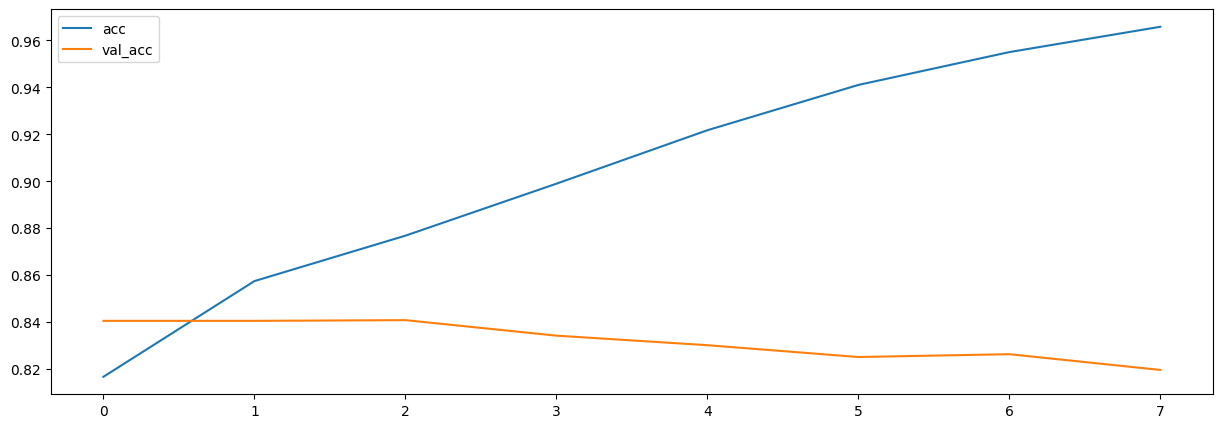

In [56]:
plt.figure(figsize=(15,5))

plt.plot(h.history['acc'], label='acc')
plt.plot(h.history['val_acc'], label= 'val_acc')
plt.legend()
plt.show()

In [1]:
review_model = Sequential()

review_model.add(Embedding(input_dim = 7851, out_dim = 50))
# 학습시 과대적합을 방지하기위해 매 epoch마다 랜덤하게 30%의 뉴런들의 학습을 비활성화 시킴
review_model.add(Dropout(0.3))

review_model.add(LSTM(128, return_sequences = True))
review_model.add(LSTM(64))

review_model.add()

NameError: ignored